# Imports y Preparacion del dataset

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import sklearn.preprocessing as skp
import scipy.stats as stats
import scipy as sc
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

#joblib
#from joblib import dump, load
import joblib

# multivariado   
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neighbors import DistanceMetric

from sklearn import metrics

from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score#, precision_recall_curve, roc_curve, 
#KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.svm import SVC



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/hotels_train.csv') 
df_test = pd.read_csv('/content/drive/MyDrive/Datasets/hotels_test.csv')
df_test_original = df_test.copy()
df_original = df.copy()


#Preprocesamiento

In [ ]:
columnas = {"adr": "average_daily_rate", "arrival_date_year":"year", "arrival_date_month":"month", "arrival_date_day_of_month":"day"} #cambiar nombres a las categorias
df.rename(columns = columnas, inplace = True)
df = df.drop(columns=['arrival_date_week_number'])
#CAMBIO EL UNDEFINED A SC :)
df.loc[df.loc[:,"meal"]=='Undefined',"meal"]="SC"
#COUNTRY
df['country'] = df['country'].fillna('PRT')
paises_comunes = ['PRT','GBR','FRA','ESP','DEU','ITA','IRL', 'BRA', 'BEL', 'USA', 'NLD', 'CHE', 'CN', 'AUT', 'CHN', 'SWE', 'POL', 'RUS', 'ISR', 'NOR']
df.loc[~df.loc[:,"country"].isin(paises_comunes),"country"]="OTHER"
#TENEMOS QUE VER LOS 2 UNDEFINED 
df.drop(df[df['market_segment']=='Undefined'].index, axis='index',inplace=True)
df.drop(df[df['distribution_channel']=='Undefined'].index, axis='index',inplace=True)
#ROOM TYPES
room_type_populares = ["A", "D", "E", "F", "G"]
df.loc[~df.loc[:,"assigned_room_type"].isin(room_type_populares),"assigned_room_type"]="O"
df.loc[~df.loc[:,"reserved_room_type"].isin(room_type_populares),"reserved_room_type"]="O"
#ARRIVAL_DATE
months = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8,'September':9, 'October':10,'November':11, 'December': 12 }
df.month = df.month.map(months)
arrivaldates = df.copy() 
import datetime

date=arrivaldates.apply(lambda x: datetime.date(int(x['year']), x['month'], x['day']),axis=1)

date = pd.to_datetime(date)

df = df.drop(columns=['year', 'month', 'day'])

df.insert(0, 'arrival_date', date)

#DROP COMPANY
df= df.drop(columns=['company', 'reservation_status_date'])
#CHILDREN
df['children'] = df['children'].fillna(0.0)
df['children'] = df['children'].astype(int)
#AGENT
df['agent'] = df['agent'].fillna(9.0)
df['agent'] = df['agent'].astype(int)


#eliminamos el outlier porque una fila respecto a la gran cantidad de datos que tenemos no es relevante
df.drop(df[df['average_daily_rate']<0].index, axis='index',inplace=True)
df.drop(df[df['average_daily_rate']==0].index, axis='index',inplace=True)
#
df.drop(df[(df['babies']==0) & (df['adults']==0) & (df['children']==0)].index, axis='index',inplace=True)
df.drop(df[(df['babies']==0) & (df['adults']==0) & (df['children']==0)].index, axis='index',inplace=True)
#creamos una nueva col para verificar el tipo de habitacion
df['assigned_equals_reserved'] = np.where(df['assigned_room_type']== df['reserved_room_type'], True, False)
df['assigned_equals_reserved']=df['assigned_equals_reserved'].astype(int)
#TEMPORADA ALTA
temporada_alta = [1,6,7,8,12]
df['temporada_alta'] = pd.DatetimeIndex(df['arrival_date']).month.isin(temporada_alta)
df['temporada_alta'] = df['temporada_alta'] .astype(int)
#DUMMIES
dataset = df.copy()
dataset = pd.get_dummies(dataset, columns=["hotel","meal","deposit_type","customer_type","country"], drop_first=True)
dataset = pd.get_dummies(dataset, columns=["distribution_channel"], drop_first=True)
dataset = pd.get_dummies(dataset, columns=["market_segment"], drop_first=True)

In [ ]:
df_test['country'] = df_test['country'].fillna('PRT')
df_test.loc[~df_test.loc[:,"country"].isin(paises_comunes),"country"]="OTHER"

df_test.drop(df_test[df_test['market_segment']=='Undefined'].index, axis='index',inplace=True)
df_test.drop(df_test[df_test['distribution_channel']=='Undefined'].index, axis='index',inplace=True)

df_test = pd.get_dummies(df_test, columns=["hotel","meal","deposit_type","customer_type","country"], drop_first=True)
df_test = pd.get_dummies(df_test, columns=["distribution_channel"], drop_first=True)
df_test = pd.get_dummies(df_test, columns=["market_segment"], drop_first=True)
df_test.rename(columns = columnas, inplace = True)
df_test = df_test.drop(columns=['arrival_date_week_number'])
df_test.month = df_test.month.map(months)
arrivaldates = df_test.copy()

date=arrivaldates.apply(lambda x: datetime.date(int(x['year']), x['month'], x['day']),axis=1)
date = pd.to_datetime(date)
df_test = df_test.drop(columns=['year', 'month', 'day'])
df_test.insert(0, 'arrival_date', date)

df_test= df_test.drop(columns=['company'])
df_test['agent'] = df_test['agent'].fillna(9.0) #Cambiamos los datos faltantes por la moda, dado que es el que mas se repite y poder afectar menos nuestra distribucion

df_test['assigned_equals_reserved'] = np.where(df_test['assigned_room_type']== df_test['reserved_room_type'], True, False) #creamos una nueva col para verificar el tipo de habitacion
df_test['assigned_equals_reserved']=df_test['assigned_equals_reserved'].astype(int)

df_test['temporada_alta'] = pd.DatetimeIndex(df_test['arrival_date']).month.isin(temporada_alta)
df_test['temporada_alta'] = df_test['temporada_alta'] .astype(int)

#CHECKPOINT 3

Para este checkpoint de ensambles solo vamos a usar variables numericas.

##a. Construir un clasificador KNN optimizar sus hiperparámetros mediante k-fold Cross Validation


###Preparacion

In [ ]:
datasetknn = dataset.drop(columns=['assigned_room_type', 'reserved_room_type', 'id', 'arrival_date'])

In [ ]:
df_knntest = df_test.copy()

In [ ]:
df_knntest = df_knntest.drop(columns=['assigned_room_type', 'reserved_room_type', 'id', 'arrival_date'])

In [ ]:
#df_knntest = pd.get_dummies(df_knntest, columns=["hotel","meal","deposit_type","customer_type","country","distribution_channel","market_segment",], drop_first=True)
df_knntest = df_knntest[['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
       'adults', 'children', 'babies', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'booking_changes', 'agent', 'days_in_waiting_list',
       'average_daily_rate', 'required_car_parking_spaces',
       'total_of_special_requests', 'assigned_equals_reserved',
       'temporada_alta', 'hotel_Resort Hotel', 'meal_FB', 'meal_HB', 'meal_SC',
       'deposit_type_Non Refund', 'deposit_type_Refundable',
       'customer_type_Group', 'customer_type_Transient',
       'customer_type_Transient-Party', 'country_BEL', 'country_BRA',
       'country_CHE', 'country_CHN', 'country_CN', 'country_DEU',
       'country_ESP', 'country_FRA', 'country_GBR', 'country_IRL',
       'country_ISR', 'country_ITA', 'country_NLD', 'country_NOR',
       'country_OTHER', 'country_POL', 'country_PRT', 'country_RUS',
       'country_SWE', 'country_USA', 'distribution_channel_Direct',
       'distribution_channel_GDS', 'distribution_channel_TA/TO',
       'market_segment_Complementary', 'market_segment_Corporate',
       'market_segment_Direct', 'market_segment_Groups',
       'market_segment_Offline TA/TO', 'market_segment_Online TA']]

In [ ]:
#Separar datos y etiquetas
x = datasetknn.iloc[:,0:56]
y = datasetknn.is_canceled
#dropeo el target
x = x.drop(columns=['is_canceled'])
#Separo conjunto de Train y de Test (80/20)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)

In [ ]:
#Crear el modelo
KNN_Classifier = KNeighborsClassifier()

#vemos sus parámetros
KNN_Classifier.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
#Entrenar el modelo
KNN_Classifier.fit(x_train, y_train)

#Predicción sobre test
y_pred = KNN_Classifier.predict(x_test)

In [ ]:
#Cantidad de aciertos
print('correctas: ', np.sum(y_test == y_pred))
print('total: ', len(y_test))

correctas:  9002
total:  12203


In [ ]:
f1_score(y_test, y_pred)

0.7441860465116278

###Submit KNN Estandar 

In [ ]:
pruebas11 = df_knntest[['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
       'adults', 'children', 'babies', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'booking_changes', 'agent', 'days_in_waiting_list',
       'average_daily_rate', 'required_car_parking_spaces',
       'total_of_special_requests', 'assigned_equals_reserved',
       'temporada_alta', 'hotel_Resort Hotel', 'meal_FB', 'meal_HB', 'meal_SC',
       'deposit_type_Non Refund', 'deposit_type_Refundable',
       'customer_type_Group', 'customer_type_Transient',
       'customer_type_Transient-Party', 'country_BEL', 'country_BRA',
       'country_CHE', 'country_CHN', 'country_CN', 'country_DEU',
       'country_ESP', 'country_FRA', 'country_GBR', 'country_IRL',
       'country_ISR', 'country_ITA', 'country_NLD', 'country_NOR',
       'country_OTHER', 'country_POL', 'country_PRT', 'country_RUS',
       'country_SWE', 'country_USA', 'distribution_channel_Direct',
       'distribution_channel_GDS', 'distribution_channel_TA/TO',
       'market_segment_Complementary', 'market_segment_Corporate',
       'market_segment_Direct', 'market_segment_Groups',
       'market_segment_Offline TA/TO', 'market_segment_Online TA']]

In [ ]:
y_pred = KNN_Classifier.predict(pruebas11)

In [ ]:
df_submission = pd.DataFrame({'id':df_test['id'], 'is_canceled':y_pred})
df_submission.head()
df_submission.shape

(26535, 2)

In [ ]:
df_submission.to_csv('/content/drive/MyDrive/submissions/submission_v11.csv', index=False)

###KNN N1

In [ ]:
#Crear el modelo,arrancamos eligiendo 10 vecinos mas cercanos y distancia euclidea
KNN_Classifier_N1 = KNeighborsClassifier(metric='euclidean', n_neighbors=10)

#vemos sus parámetros
KNN_Classifier.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
#Entrenar el modelo
KNN_Classifier_N1.fit(x_train, y_train)

#Predicción sobre test
y_pred = KNN_Classifier_N1.predict(x_test)

In [ ]:
#Cantidad de aciertos
print('correctas: ', np.sum(y_test == y_pred))
print('total: ', len(y_test))

correctas:  8915
total:  12203


In [ ]:
f1_score(y_test,y_pred)

0.7256341789052071

###KNN N2

In [ ]:
#Crear el modelo, decido aumentar la cantidad de vecinos cercanos
KNN_Classifier_N2 = KNeighborsClassifier(metric='euclidean', n_neighbors=35)

#vemos sus parámetros
KNN_Classifier_N2.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
#Entrenar el modelo
KNN_Classifier_N2.fit(x_train, y_train)

#Predicción sobre test
y_pred = KNN_Classifier_N2.predict(x_test)

In [ ]:
#Cantidad de aciertos
print('correctas: ', np.sum(y_test == y_pred))
print('total: ', len(y_test))

correctas:  8528
total:  12203


In [ ]:
f1_score(y_test,y_pred)

0.7132714363735665

###KNN N3

In [ ]:
#Crear el modelo, seguimos aumentando la cant de vecinos con la misma metrica de distancia
KNN_Classifier_N3 = KNeighborsClassifier(metric='euclidean', n_neighbors=85)

#vemos sus parámetros
KNN_Classifier_N3.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
#Entrenar el modelo
KNN_Classifier_N3.fit(x_train, y_train)

#Predicción sobre test
y_pred = KNN_Classifier_N3.predict(x_test)

In [ ]:
#Cantidad de aciertos
print('correctas: ', np.sum(y_test == y_pred))
print('total: ', len(y_test))

correctas:  8286
total:  12203


In [ ]:
f1_score(y_test,y_pred)

0.6960502832311631

In [ ]:
accuracy_score(y_test,y_pred)

0.6790133573711382

###KNN N4

In [ ]:
#Crear el modelo, misma cantidad de vecinos, con la metrica de distancia por default
KNN_Classifier_N4 = KNeighborsClassifier(n_neighbors=85)

#vemos sus parámetros
KNN_Classifier_N4.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
#Entrenar el modelo
KNN_Classifier_N4.fit(x_train, y_train)

#Predicción sobre test
y_pred = KNN_Classifier_N4.predict(x_test)

In [ ]:
#Cantidad de aciertos
print('correctas: ', np.sum(y_test == y_pred))
print('total: ', len(y_test))

correctas:  8286
total:  12203


In [ ]:
f1_score(y_test,y_pred)

0.6960502832311631

In [ ]:
accuracy_score(y_test,y_pred)

0.6790133573711382

###KNN N5

In [ ]:
#Crear el modelo, aumento la cantidad de vecinos
KNN_Classifier_N5 = KNeighborsClassifier(n_neighbors=165)

#vemos sus parámetros
KNN_Classifier.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
#Entrenar el modelo
KNN_Classifier_N5.fit(x_train, y_train)

#Predicción sobre test
y_pred = KNN_Classifier_N5.predict(x_test)

In [ ]:
#Cantidad de aciertos
print('correctas: ', np.sum(y_test == y_pred))
print('total: ', len(y_test))

correctas:  8081
total:  12203


In [ ]:
f1_score(y_test,y_pred) 

0.6863968350578211

En base a esto podria deducir que a medida que aumentamos la cantidad de vecinos, f1 score disminuye. Pero decidimos seguir probando

###KNN N6

In [ ]:
#Crear el modelo, probamos si nuestra sospecha es cierta y disminuimos el numero de vecinos
KNN_Classifier_N6 = KNeighborsClassifier(metric='euclidean',n_neighbors=4)

#vemos sus parámetros
KNN_Classifier_N6.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
#Entrenar el modelo
KNN_Classifier_N6.fit(x_train, y_train)

#Predicción sobre test
y_pred = KNN_Classifier_N6.predict(x_test)

In [ ]:
#Cantidad de aciertos
print('correctas: ', np.sum(y_test == y_pred))
print('total: ', len(y_test))

correctas:  9153
total:  12203


In [ ]:
f1_score(y_test,y_pred) 

0.7326906222611743

### KNN N7

In [ ]:
#Crear el modelo, decidimos usar la metrica de distancia euclidea, con una cant de vecinos baja.
KNN_Classifier_N7 = KNeighborsClassifier(metric='euclidean',n_neighbors=5)

#vemos sus parámetros
KNN_Classifier.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
#Entrenar el modelo
KNN_Classifier_N7.fit(x_train, y_train)

#Predicción sobre test
y_pred = KNN_Classifier_N7.predict(x_test)

In [ ]:
#Cantidad de aciertos
print('correctas: ', np.sum(y_test == y_pred))
print('total: ', len(y_test))

correctas:  9002
total:  12203


In [ ]:
f1_score(y_test,y_pred)

0.7441860465116278

In [ ]:
accuracy_score(y_test,y_pred)

0.7376874539047775

###KNN N8

In [ ]:
#Crear el modelo, decidimos bajar mucho mas la cant de vecinos
KNN_Classifier_N8 = KNeighborsClassifier(metric='euclidean',n_neighbors=3)

#vemos sus parámetros
KNN_Classifier_N8.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
#Entrenar el modelo
KNN_Classifier_N8.fit(x_train, y_train)

#Predicción sobre test
y_pred = KNN_Classifier_N8.predict(x_test)

In [ ]:
#Cantidad de aciertos
print('correctas: ', np.sum(y_test == y_pred))
print('total: ', len(y_test))

correctas:  9111
total:  12203


In [ ]:
f1_score(y_test,y_pred)

###KNN N9

In [ ]:
#Crear el modelo, seguimos probando
KNN_Classifier_N9 = KNeighborsClassifier(n_neighbors=3)

#vemos sus parámetros
KNN_Classifier.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
#Entrenar el modelo
KNN_Classifier_N9.fit(x_train, y_train)

#Predicción sobre test
y_pred = KNN_Classifier_N9.predict(x_test)

In [ ]:
#Cantidad de aciertos
print('correctas: ', np.sum(y_test == y_pred))
print('total: ', len(y_test))

correctas:  9111
total:  12203


In [ ]:
accuracy_score(y_test,y_pred)

0.74661968368434

Despues de tantas pruebas, es muy probable que la relacion entre la cantidad de vecinos y el f1score es inversa. Por lo que decidimos elegir rangos y verlos graficamente

###KNN Rango 1 a 50

Inicialmente quisimos probar con todo el tamaño de x, pero iba atomar mucho tiempo. Por lo que decidimos arrancar de 1 a 50 vecinos

In [ ]:
from sklearn.model_selection import cross_val_score

k_range=range(1,50) #canidad de vecinos a probar

k_scores=[] # accuracy para cada K utilizado

for k in k_range:
    #clasificador Knn
    knn=KNeighborsClassifier(n_neighbors=k)
    #uso 10 folds
    scores=cross_val_score(knn,x_train,y_train,cv=10,scoring='accuracy')
    #promedio las 10 métricas
    k_scores.append(scores.mean())

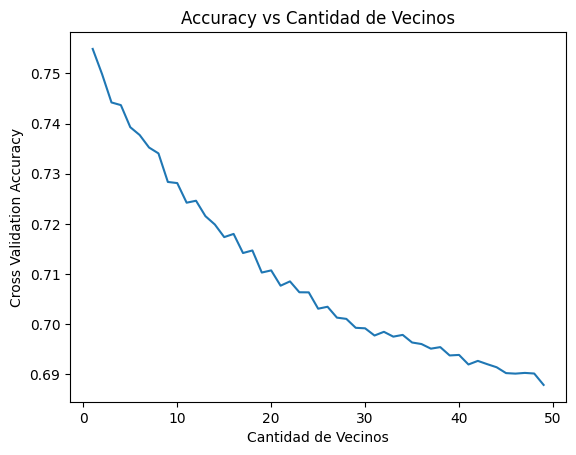

In [ ]:
#ploteamos accuracy vs cantidad de vecinos
plt.plot(k_range, k_scores)
plt.xlabel('Cantidad de Vecinos')
plt.ylabel('Cross Validation F1Score')
plt.title('Accuracy vs Cantidad de Vecinos')
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score

k_range=range(1,50) #canidad de vecinos a probar

k_scores=[] # accuracy para cada K utilizado

for k in k_range:
    #clasificador Knn
    knn=KNeighborsClassifier(n_neighbors=k)
    #uso 10 folds
    scores=cross_val_score(knn,x_train,y_train,cv=10,scoring='f1')
    #promedio las 10 métricas
    k_scores.append(scores.mean())

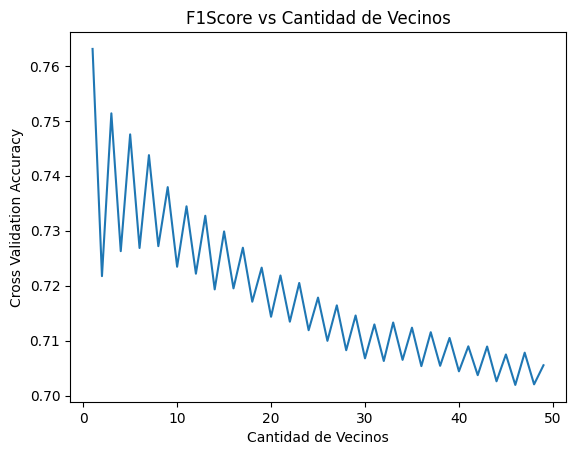

In [ ]:
#ploteamos f1score vs cantidad de vecinos
plt.plot(k_range, k_scores)
plt.xlabel('Cantidad de Vecinos')
plt.ylabel('Cross Validation F1Score')
plt.title('F1Score vs Cantidad de Vecinos')
plt.show()

Vemos que el mejor F1_Score lo vamos a obtener con una cantidad pequeña de vecinos

###KNN Rango 50 a 80

Por las dudas, decidimos incrementar un poco mas nuestro rango

In [ ]:
from sklearn.model_selection import cross_val_score

k_range=range(50,80) #canidad de vecinos a probar

k_scores=[] # accuracy para cada K utilizado

for k in k_range:
    #clasificador Knn
    knn=KNeighborsClassifier(n_neighbors=k)
    #uso 10 folds
    scores=cross_val_score(knn,x_train,y_train,cv=10,scoring='accuracy')
    #promedio las 10 métricas
    k_scores.append(scores.mean())

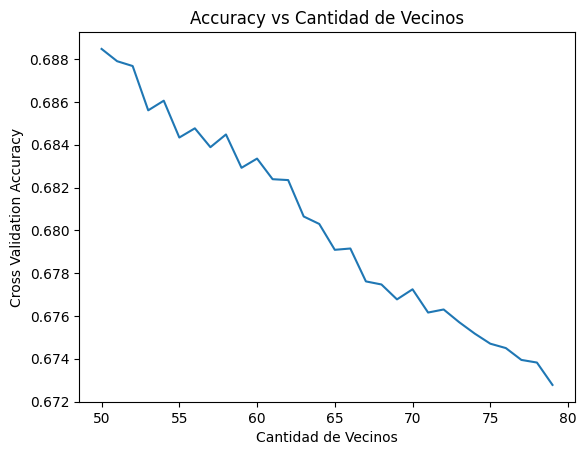

In [ ]:
#ploteamos accuracy vs cantidad de vecinos
plt.plot(k_range, k_scores)
plt.xlabel('Cantidad de Vecinos')
plt.ylabel('Cross Validation Accuracy')
plt.title('Accuracy vs Cantidad de Vecinos')
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score

k_range=range(50,80) #canidad de vecinos a probar

k_scores=[] # accuracy para cada K utilizado

for k in k_range:
    #clasificador Knn
    knn=KNeighborsClassifier(n_neighbors=k)
    #uso 10 folds
    scores=cross_val_score(knn,x_train,y_train,cv=10,scoring='f1') #PRUEBO CON F1SCORE
    #promedio las 10 métricas
    k_scores.append(scores.mean())

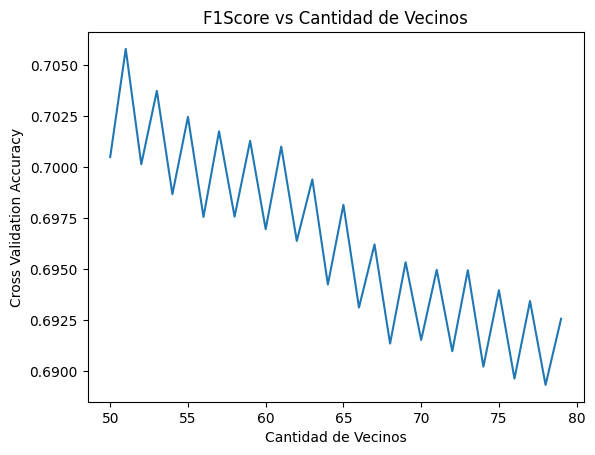

In [ ]:
#ploteamos f1Score vs cantidad de vecinos
plt.plot(k_range, k_scores)
plt.xlabel('Cantidad de Vecinos')
plt.ylabel('Cross Validation Accuracy')
plt.title('F1Score vs Cantidad de Vecinos')
plt.show()

Comprobamos nuestra sospecha, la relacion entre la cant de vecinos y mi metrica f1_score es inversa

###Random Search KNN

Decidimos buscar nuestros mejores parametros, como anteriormente vimos decidimos usar un rango de 1 a 12 vecinos para esta busqueda. 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV #HACEMOS VALIDACION CRUZADA PARA BUSCAR HIPERPARAMETROS 

#Grilla de Parámetros
params_grid={ 'n_neighbors':range(1,12), 
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree'],
              'metric':['euclidean','manhattan','chebyshev'] #ESAS 3 SIRVEN PARA CUALQUIER ALGORITMO
             }
#Clasificador KNN
knn=KNeighborsClassifier()

#Random Search con 10 Folds y 10 iteraciones
rand = RandomizedSearchCV(knn, params_grid, cv=10, scoring='f1', n_iter=10, random_state=5) #LE DAMOS EL KNN BASE, QUE BUSQUE HACIENDO 10 FOLDS, QUE BUSQUE 10 JUEGOS DE PARAMETROS(n_iter)
#CV = CANTIDAD DE VECES QUE SE VALIDA

rand.fit(x_train, y_train) #LO ENTRENO
rand.cv_results_['mean_test_score'] #DAME EL PROMEDIO DE TU SCORE, PORQUE PODRIA DARME UN CASO BORDE SI LE PIDO EL MAXIMO

array([0.75444824, 0.77726735, 0.79918971, 0.75023373, 0.79896889,
       0.75669771, 0.76356238, 0.73499748, 0.77017825, 0.74927201])

In [ ]:
joblib.dump(rand, 'knn_best_model.pkl')

['knn_best_model.pkl']

In [ ]:
#Mejores hiperparametros AHORA SI LE PIDO EL MEJOR SET DE PARAMETROS CON LA MEJOR METRICA
print(rand.best_params_)
#Mejor métrica
print(rand.best_score_)

{'weights': 'distance', 'n_neighbors': 11, 'metric': 'manhattan', 'algorithm': 'ball_tree'}
0.7991897104730591


In [ ]:
#Predicción sobre test
y_pred = rand.predict(x_test)

In [ ]:
#Predicción sobre test
predicciones = rand.predict(df_knntest)

In [ ]:
df_submission = pd.DataFrame({'id':df_test['id'], 'is_canceled':predicciones})
df_submission.head()
df_submission.shape


(26535, 2)

In [ ]:
#df_submission.to_csv('/content/drive/MyDrive/submissions/submission_KNN.csv', index=False)

###Matriz de confusion

Text(50.722222222222214, 0.5, 'True')

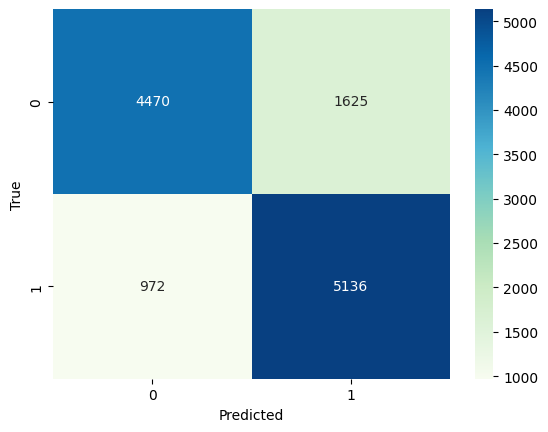

In [ ]:
#Creo la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Concluimos con esa matriz de confusion que hizo buenas predicciones, por lo que vemos tiene un buen accuracy y f1_score

In [ ]:
knn = rand


##b. Construir un clasificador SVM variando el kernel y los parámetros.



###Preparacion

In [ ]:
features = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
       'adults', 'children', 'babies', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'booking_changes', 'agent', 'days_in_waiting_list',
       'average_daily_rate', 'required_car_parking_spaces',
       'total_of_special_requests', 'assigned_equals_reserved',
       'temporada_alta', 'hotel_Resort Hotel', 'meal_FB', 'meal_HB', 'meal_SC',
       'deposit_type_Non Refund', 'deposit_type_Refundable',
       'customer_type_Group', 'customer_type_Transient',
       'customer_type_Transient-Party', 'country_BEL', 'country_BRA',
       'country_CHE', 'country_CHN', 'country_CN', 'country_DEU',
       'country_ESP', 'country_FRA', 'country_GBR', 'country_IRL',
       'country_ISR', 'country_ITA', 'country_NLD', 'country_NOR',
       'country_OTHER', 'country_POL', 'country_PRT', 'country_RUS',
       'country_SWE', 'country_USA', 'distribution_channel_Direct',
       'distribution_channel_GDS', 'distribution_channel_TA/TO',
       'market_segment_Complementary', 'market_segment_Corporate',
       'market_segment_Direct', 'market_segment_Groups',
       'market_segment_Offline TA/TO', 'market_segment_Online TA']

In [ ]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

In [ ]:
target= 'is_canceled'

In [ ]:
datasetsvm = dataset.drop(columns=['assigned_room_type', 'reserved_room_type', 'id', 'arrival_date'])

In [ ]:
df_svmtest = df_test.copy()

In [ ]:
df_svmtest = df_svmtest.drop(columns=['assigned_room_type', 'reserved_room_type', 'id', 'arrival_date'])

In [ ]:
df_svmtest = df_svmtest[features]
      

###Preprocesamiento

In [ ]:
#Creo conjuntos de train y test
x_train, x_test, y_train, y_test = train_test_split(datasetsvm[features].values, datasetsvm[target].values, test_size=0.2, random_state=0)

#Armo una version escalada con minmax (media=0 , var=1  )
min_max_scaler = skp.MinMaxScaler()
x_train_minmax = min_max_scaler.fit_transform(x_train) #transformo a min max
x_test_minmax  = min_max_scaler.transform(x_test) 

#Armo una version estandarizada
stand_scaler = skp.StandardScaler()
x_train_norm = stand_scaler.fit_transform(x_train) #transformo standar
x_test_norm=stand_scaler.transform(x_test)

###SVM Estandar

Decidimos arrancar con un caso base, sin parametros, sin normalizar los datos

In [ ]:
#Construyo un modelo SVM  
svm = SVC()

#Lo entreno con los datos sin escalar PRUEBO ENTRENANDO SIN NORMALIZAR
svm.fit(x_train, y_train)

#Hago la prediccion y calculo las métricas
y_pred=svm.predict(x_test)
metricas(y_pred,y_test)

###SVM Normalizado

Ahora decidimos que los datos tengan una desviacion estandar de 1, dado que con esa transformacion podemos mejorar los resultados

In [ ]:
#Construyo un modelo SVM CON LOS TRANSFORMADOS POR STANDAR
svm_norm= SVC()

#Lo entreno con los datos escalados con normalizacion
svm_norm.fit(x_train_norm, y_train)

#Hago la prediccion y calculo las métricas
y_pred_norm=svm_norm.predict(x_test_norm)
metricas(y_pred_norm,y_test)

              precision    recall  f1-score   support

           0       0.84      0.81      0.83      6095
           1       0.82      0.84      0.83      6108

    accuracy                           0.83     12203
   macro avg       0.83      0.83      0.83     12203
weighted avg       0.83      0.83      0.83     12203



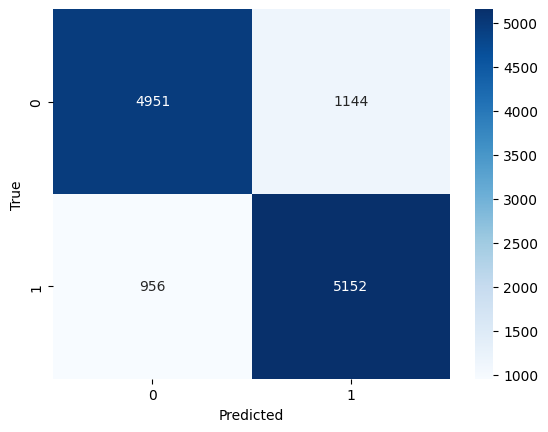

In [ ]:
#Construyo un modelo SVM TRANSFORMADO POR MIN MAX
svm_minmax= SVC()

#Lo entreno con los datos escalados con min max
svm_minmax.fit(x_train_minmax, y_train)

#Hago la prediccion y calculo las métricas
y_pred_minmax=svm_minmax.predict(x_test_minmax)
metricas(y_pred_minmax,y_test)

###SVM GridSearch Busqueda hiperparametros


Es importante tener buenos hiperparametros de regularizacion para evitar el overfitting. En estos casos es mejor usar Grid Search que Random Search dado el primero evalua todas las combinaciones. 

Busqueda de hiperparametros Kernel Lineal

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold,KFold
from sklearn.metrics import make_scorer  
# defining parameter range
param_grid = {'C': [0.1, 1, 5], 
              'gamma': [0.01,0.001], #NO LO USA EL LINEAL
              'kernel': ['linear']} 
folds = 4
kfoldcv = StratifiedKFold(n_splits=folds) #RESPETE LA PROPORCION DE LA CLASE, EN LA MISMA PROPORCION ORIGINAL
scorer_fn = make_scorer(sk.metrics.f1_score)
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,scoring = scorer_fn,cv=kfoldcv)
  
# fitting the model for grid search
grid.fit(x_train_minmax, y_train)


Demoro mucho en ejecutarse pero obtuvimos estos parametros: C=5 ->f1score: 0.807

Busqueda de Hiperparametros Kernel Radial

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold,KFold
from sklearn.metrics import make_scorer  
# defining parameter range
param_grid = {'C': [0.1, 1, 5], 
              'gamma': [0.01,0.001],
              'kernel': ['rbf']} #PARA RADIAL KERNEL DESPUES DE VARIAS PRUEBAS OBTUVIMOS QUE LOS MEJORES HIPERPARAMETROS SON: C=5 y gamma= 0.01
folds = 4
kfoldcv = StratifiedKFold(n_splits=folds) #RESPETE LA PROPORCION DE LA CLASE, EN LA MISMA PROPORCION ORIGINAL
scorer_fn = make_scorer(sk.metrics.f1_score)
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,scoring = scorer_fn,cv=kfoldcv)
  
# fitting the model for grid search
grid.fit(x_train_minmax, y_train)


Mejores hiperparametros : C=5 y gamma= 0.01 ->f1score : 0.811

Busqueda de Hiperparametros Kernel Polinomial

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold,KFold
from sklearn.metrics import make_scorer  
# defining parameter range
param_grid = {'C': [0.1, 1, 5], 
              'gamma': [5, 0.01,0.001],
              'kernel': ['poly']
              } 
folds = 4
kfoldcv = StratifiedKFold(n_splits=folds) #RESPETE LA PROPORCION DE LA CLASE, EN LA MISMA PROPORCION ORIGINAL
scorer_fn = make_scorer(sk.metrics.f1_score)
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,scoring = scorer_fn,cv=kfoldcv)
  
# fitting the model for grid search
grid.fit(x_train_minmax, y_train)


Mejores hiperparametros : C=0.1 y gamma=5 f1score = 0.833

###SVM Kernel Lineal

Usando los best parameters obtenidos

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      6095
           1       0.81      0.81      0.81      6108

    accuracy                           0.81     12203
   macro avg       0.81      0.81      0.81     12203
weighted avg       0.81      0.81      0.81     12203



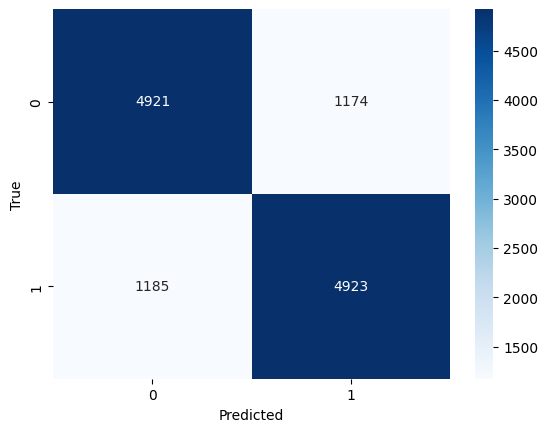

In [ ]:
#Creo un clasificador con kernel lineal y lo entreno sobre los datos escalados min-max 
clf = SVC(kernel='linear', C=5)
clf.fit(x_train_minmax, y_train)

#Hago la predicción y calculo las métricas
y_pred_lin=clf.predict(x_test_minmax)
metricas(y_pred_lin,y_test)

In [ ]:
predicciones_knnlineal =clf.predict(df_svmtest.values)

In [ ]:
df_submission = pd.DataFrame({'id':df_test['id'], 'is_canceled':predicciones_knnlineal})
df_submission.head()
df_submission.shape

(26535, 2)

In [ ]:
df_submission.to_csv('/content/drive/MyDrive/submissions/submission_svmklineal.csv', index=False)

In [ ]:
joblib.dump(clf, 'svm_klineal_best_model.pkl')

['svm_klineal_best_model.pkl']

###SVM Kernel Polinomico

Usando los best parameters obtenidos

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold,KFold
from sklearn.metrics import make_scorer
# defining parameter range
param_grid = {'C': [0.1], 
              'gamma': [5],
              'kernel': ['poly'],
              } 
folds = 4
kfoldcv = StratifiedKFold(n_splits=folds) #RESPETE LA PROPORCION DE LA CLASE, EN LA MISMA PROPORCION ORIGINAL
scorer_fn = make_scorer(sk.metrics.f1_score)
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,scoring = scorer_fn,cv=kfoldcv)

# fitting the model for grid search
grid.fit(x_train_minmax, y_train)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV 1/4] END .......C=0.1, gamma=5, kernel=poly;, score=0.833 total time=26.9min
[CV 2/4] END .......C=0.1, gamma=5, kernel=poly;, score=0.836 total time=24.6min
[CV 3/4] END .......C=0.1, gamma=5, kernel=poly;, score=0.835 total time=25.4min
[CV 4/4] END .......C=0.1, gamma=5, kernel=poly;, score=0.837 total time=23.8min


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=SVC(),
             param_grid={'C': [0.1], 'gamma': [5], 'kernel': ['poly']},
             scoring=make_scorer(f1_score), verbose=3)

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      6095
           1       0.83      0.85      0.84      6108

    accuracy                           0.84     12203
   macro avg       0.84      0.84      0.84     12203
weighted avg       0.84      0.84      0.84     12203



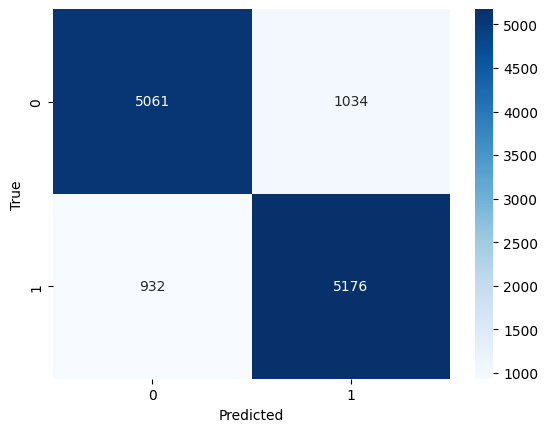

In [ ]:
y_pred_pol=grid.predict(x_test_minmax)
metricas(y_pred_pol,y_test)

In [ ]:
predicciones_svm_kpolinomial =grid.predict(df_svmtest.values)

In [ ]:
df_submission = pd.DataFrame({'id':df_test['id'], 'is_canceled':predicciones_svm_kpolinomial})
df_submission.head()
df_submission.shape

(26535, 2)

In [ ]:
df_submission.to_csv('/content/drive/MyDrive/submissions/submission_svmkpolinomial.csv', index=False)

In [ ]:
joblib.dump(grid, 'svm_kpolinomial_best_model.pkl')

['svm_kpolinomial_best_model.pkl']

###Kernel Radial

Usando los best parameters obtenidos

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      6095
           1       0.80      0.83      0.82      6108

    accuracy                           0.81     12203
   macro avg       0.81      0.81      0.81     12203
weighted avg       0.81      0.81      0.81     12203



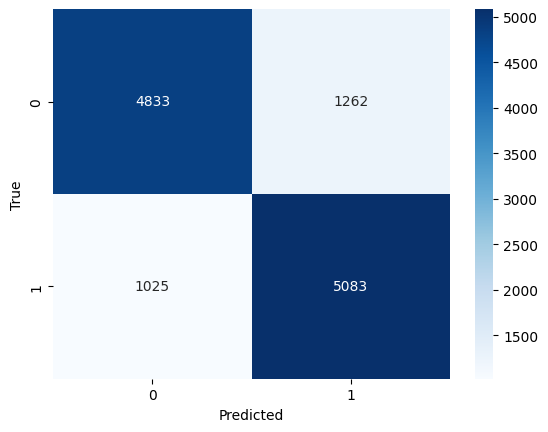

In [ ]:
#Creo un clasificador con kernel radial y lo entreno sobre los datos escalados min-max CON LOS BEST PARAMETERS
clf = SVC(kernel='rbf', C=5, gamma=0.01)
clf.fit(x_train_minmax, y_train)

#Hago la predicción y calculo las métricas
y_pred_rad=clf.predict(x_test_minmax)
metricas(y_pred_rad,y_test)

In [ ]:
predicciones_svm_kradial =clf.predict(df_svmtest.values)

In [ ]:
df_submission = pd.DataFrame({'id':df_test['id'], 'is_canceled':predicciones_svm_kradial})
df_submission.head()
df_submission.shape

(26535, 2)

In [ ]:
df_submission.to_csv('/content/drive/MyDrive/submissions/submission_svmkradial.csv', index=False)

In [ ]:
joblib.dump(clf, 'svm_kradial_best_model.pkl')

['svm_kradial_best_model.pkl']

In [ ]:
svm_radial = clf;

##c. Construir un clasificador RF y optimizar sus hiperparámetros mediante k-fold Cross Validation


###Random Forest GridSearch

####Preparacion

In [ ]:
features = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
       'adults', 'children', 'babies', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'booking_changes', 'agent', 'days_in_waiting_list',
       'average_daily_rate', 'required_car_parking_spaces',
       'total_of_special_requests', 'assigned_equals_reserved',
       'temporada_alta', 'hotel_Resort Hotel', 'meal_FB', 'meal_HB', 'meal_SC',
       'deposit_type_Non Refund', 'deposit_type_Refundable',
       'customer_type_Group', 'customer_type_Transient',
       'customer_type_Transient-Party', 'country_BEL', 'country_BRA',
       'country_CHE', 'country_CHN', 'country_CN', 'country_DEU',
       'country_ESP', 'country_FRA', 'country_GBR', 'country_IRL',
       'country_ISR', 'country_ITA', 'country_NLD', 'country_NOR',
       'country_OTHER', 'country_POL', 'country_PRT', 'country_RUS',
       'country_SWE', 'country_USA', 'distribution_channel_Direct',
       'distribution_channel_GDS', 'distribution_channel_TA/TO',
       'market_segment_Complementary', 'market_segment_Corporate',
       'market_segment_Direct', 'market_segment_Groups',
       'market_segment_Offline TA/TO', 'market_segment_Online TA']

In [ ]:
target= 'is_canceled'

In [ ]:
datasetRF = dataset.drop(columns=['assigned_room_type', 'reserved_room_type', 'id', 'arrival_date'])

In [ ]:
df_RFtest = df_test.copy()

In [ ]:
df_RFtest = df_RFtest.drop(columns=['assigned_room_type', 'reserved_room_type', 'id', 'arrival_date'])

In [ ]:
df_RFtest = df_RFtest[features]
      

In [ ]:
#Creo conjuntos de train y test
x_train, x_test, y_train, y_test = train_test_split(datasetRF[features].values, datasetRF[target].values, test_size=0.2, random_state=0)


####RF con 5 folds

In [ ]:
rf_cv = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"], 
               "min_samples_leaf" : [1, 5, 10], 
               "min_samples_split" : [2, 4, 10, 12, 16], 
               "n_estimators": [10,20, 50] }

#Probamos entrenando sólo con 1 métrica
gs = GridSearchCV(estimator=rf_cv, param_grid=param_grid, scoring="f1", cv=5, n_jobs=-1)
gs_fit = gs.fit(X = x_train, y = y_train)

In [ ]:
gs_fit.best_params_

{'criterion': 'gini',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 50}

In [ ]:
print("f1_score en entrenamiento con cv: "+str(gs_fit.best_score_))

f1_score en entrenamiento con cv: 0.8735734374984178


In [ ]:
#Obtenemos el mejor modelo
rf_cv_best=gs_fit.best_estimator_

#Predicción
y_pred_rf_cv_best = rf_cv_best.predict(x_test)

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      6095
           1       0.87      0.87      0.87      6108

    accuracy                           0.87     12203
   macro avg       0.87      0.87      0.87     12203
weighted avg       0.87      0.87      0.87     12203



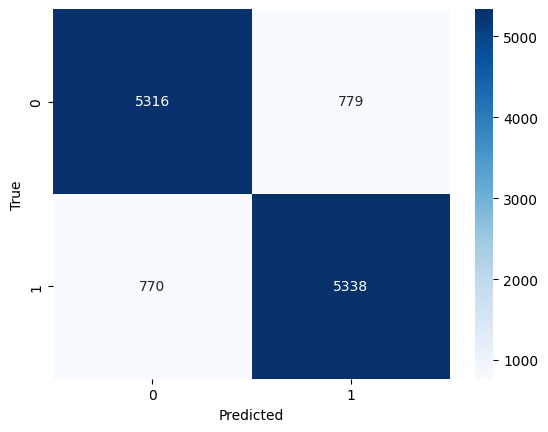

In [ ]:
#Creo matriz de confusión
tabla=confusion_matrix(y_test,y_pred_rf_cv_best)

#Grafico matriz de confusión
sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(y_test,y_pred_rf_cv_best))

In [ ]:
#Evaluo la performance en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred_rf_cv_best)
recall=recall_score(y_test,y_pred_rf_cv_best)
f1=f1_score(y_test,y_pred_rf_cv_best)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

Accuracy: 0.8730640006555765
Recall: 0.8739358218729535
f1 score: 0.8732924335378323


####Best RF

Usando Grid Search buscamos los mejores parametros, usando 10 folds

In [ ]:
rf_cv = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"], 
               "min_samples_leaf" : [1, 5, 10], 
               "min_samples_split" : [2, 4, 10, 12, 16], 
               "n_estimators": [10,20, 50] }

#Probamos entrenando sólo con 1 métrica
gs = GridSearchCV(estimator=rf_cv, param_grid=param_grid, scoring="f1", cv=10, n_jobs=-1)
gs_fit = gs.fit(X = x_train, y = y_train)

In [ ]:
gs_fit.best_params_

{'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 50}

In [ ]:
print("f1_score en entrenamiento con cv: "+str(gs_fit.best_score_))

f1_score en entrenamiento con cv: 0.8757776336086153


In [ ]:
#Obtenemos el mejor modelo
rf_cv_best=gs_fit.best_estimator_

#Predicción
y_pred_rf_cv_best = rf_cv_best.predict(x_test)

              precision    recall  f1-score   support

           0       0.88      0.87      0.87      6095
           1       0.87      0.88      0.88      6108

    accuracy                           0.87     12203
   macro avg       0.87      0.87      0.87     12203
weighted avg       0.87      0.87      0.87     12203



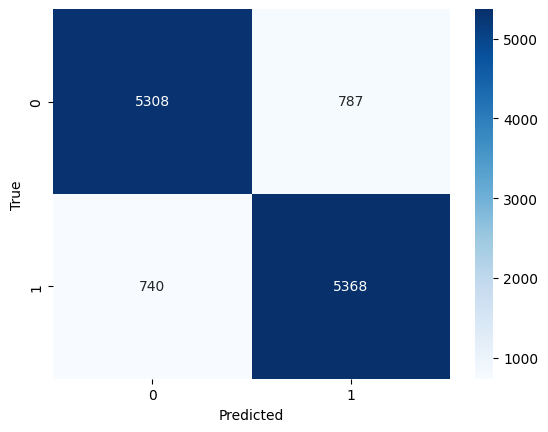

In [ ]:
#Creo matriz de confusión
tabla=confusion_matrix(y_test,y_pred_rf_cv_best)

#Grafico matriz de confusión
sns.heatmap(tabla, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(y_test,y_pred_rf_cv_best))

In [ ]:
#Evaluo la performance en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred_rf_cv_best)
recall=recall_score(y_test,y_pred_rf_cv_best)
f1=f1_score(y_test,y_pred_rf_cv_best)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

Accuracy: 0.8748668360239286
Recall: 0.8788474132285528
f1 score: 0.875479083421675


##d. Construir un clasificador XGBoost y optimizar sus hiperparámetros.


###XGBoost

In [ ]:
#Creo el modelo y lo entreno

import xgboost as xgb

xgb_model = xgb.XGBClassifier(random_state=0, n_estimators=100)
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      6095
           1       0.86      0.88      0.87      6108

    accuracy                           0.86     12203
   macro avg       0.86      0.86      0.86     12203
weighted avg       0.86      0.86      0.86     12203



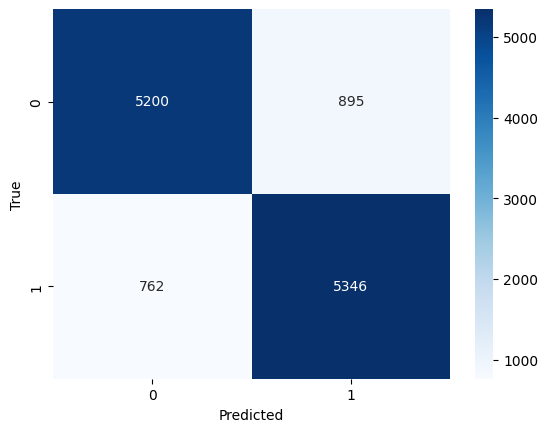

In [ ]:
#Evaluo en el set de test
y_pred= xgb_model.predict_proba(x_test)[:, 1]

#Matriz de Confusion
y_pred=xgb_model.predict(x_test)

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(y_test,y_pred))


###Optimizacion de HiperParametros

Empiezo a probar distintos valores para el learning rate, dado que la metrica me quede mas alta y la desviacion disminuya.

In [ ]:
#Datos de entrenamiento en formato DMatrix
data_dmatrix = xgb.DMatrix(data=x_train, label=y_train)

#Entreno CV para probar el learning rate
results=xgb.cv(dtrain=data_dmatrix,nfold=10,params={'learning_rate': 0.0001},num_boost_round=8,metrics='auc')
results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.889914,0.000611,0.888295,0.003807
1,0.889917,0.000610,0.888312,0.003796
2,0.889915,0.000610,0.888312,0.003796
3,0.889917,0.000610,0.888312,0.003796
4,0.889916,0.000610,0.888312,0.003796
5,0.889917,0.000610,0.888312,0.003796
6,0.889916,0.000610,0.888312,0.003796
7,0.889917,0.000610,0.888305,0.003799


In [ ]:
#Entreno CV para probar con un learning rate mas alto
results=xgb.cv(dtrain=data_dmatrix,nfold=10,params={'learning_rate':0.001},num_boost_round=8,metrics='auc',seed=0)
#, 0.001, 0.01, 0.1, 0.2, 0.3
results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.889914,0.000611,0.888289,0.003810
1,0.889917,0.000610,0.888305,0.003799
2,0.889928,0.000612,0.888320,0.003790
3,0.889937,0.000613,0.888321,0.003789
4,0.889932,0.000613,0.888323,0.003788
5,0.889933,0.000612,0.888324,0.003788
6,0.889934,0.000613,0.888326,0.003786
7,0.889935,0.000610,0.888325,0.003789


In [ ]:
#Entreno CV para probar con un learning rate mas alto
results=xgb.cv(dtrain=data_dmatrix,nfold=10,params={'learning_rate':0.01},num_boost_round=8,metrics='auc',seed=0)
#, 0.001, 0.01, 0.1, 0.2, 0.3
results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.889914,0.000611,0.888289,0.003810
1,0.890015,0.000701,0.888464,0.003639
2,0.890397,0.000802,0.888922,0.003810
3,0.890384,0.000772,0.888909,0.003810
4,0.890431,0.000763,0.888958,0.003704
5,0.890542,0.000674,0.889162,0.003824
6,0.890580,0.000687,0.889193,0.003801
7,0.890768,0.000718,0.889360,0.003714


In [ ]:
#Entreno CV para probar con un learning rate mas alto
results=xgb.cv(dtrain=data_dmatrix,nfold=10,params={'learning_rate':0.011},num_boost_round=8,metrics='auc',seed=0)
results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.889914,0.000611,0.888289,0.003810
1,0.890016,0.000702,0.888465,0.003638
2,0.890399,0.000807,0.888924,0.003813
3,0.890441,0.000770,0.888965,0.003746
4,0.890483,0.000782,0.889014,0.003660
5,0.890555,0.000678,0.889194,0.003808
6,0.890775,0.000757,0.889378,0.003705
7,0.890834,0.000731,0.889447,0.003669


In [ ]:
#Entreno CV para probar el learning rate mas alto
#MEJOR RESULTADO
results=xgb.cv(dtrain=data_dmatrix,nfold=10,params={'learning_rate':0.012},num_boost_round=8,metrics='auc',seed=0)
results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.889914,0.000611,0.888289,0.003810
1,0.890016,0.000702,0.888450,0.003658
2,0.890399,0.000807,0.888919,0.003820
3,0.890419,0.000730,0.889007,0.003697
4,0.890556,0.000684,0.889146,0.003790
5,0.890566,0.000688,0.889187,0.003813
6,0.890832,0.000737,0.889434,0.003673
7,0.890871,0.000744,0.889533,0.003651


In [ ]:
#Entreno CV para probar el learning rate mas alto
results=xgb.cv(dtrain=data_dmatrix,nfold=10,params={'learning_rate':0.0125},num_boost_round=8,metrics='auc',seed=0)
results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.889914,0.000611,0.888289,0.003810
1,0.890016,0.000702,0.888450,0.003658
2,0.890415,0.000806,0.888909,0.003812
3,0.890422,0.000731,0.889020,0.003713
4,0.890564,0.000685,0.889149,0.003793
5,0.890729,0.000766,0.889325,0.003700
6,0.890826,0.000727,0.889445,0.003673
7,0.890896,0.000762,0.889506,0.003650


In [ ]:
#NOS PASAMOS
#Entreno CV para probar el learning rate mas alto
results=xgb.cv(dtrain=data_dmatrix,nfold=10,params={'learning_rate':0.015},num_boost_round=8,metrics='auc',seed=0)
results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.889914,0.000611,0.888289,0.003810
1,0.890251,0.000674,0.888648,0.003822
2,0.890418,0.000798,0.888910,0.003814
3,0.890412,0.000714,0.888985,0.003750
4,0.890542,0.000668,0.889121,0.003833
5,0.890784,0.000723,0.889408,0.003670
6,0.890996,0.000828,0.889538,0.003614
7,0.891212,0.000512,0.889823,0.004160


In [ ]:
#NOS PASAMOS
#Entreno CV para probar el learning rate mas alto
results=xgb.cv(dtrain=data_dmatrix,nfold=10,params={'learning_rate':0.02},num_boost_round=8,metrics='auc',seed=0)
#, 0.001, 0.01, 0.1, 0.2, 0.3
results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.889914,0.000611,0.888289,0.003810
1,0.890327,0.000735,0.888885,0.003790
2,0.890458,0.000778,0.888994,0.003686
3,0.890560,0.000677,0.889210,0.003821
4,0.890880,0.000743,0.889436,0.003612
5,0.891184,0.000515,0.889783,0.004097
6,0.891247,0.000529,0.889798,0.004115
7,0.892243,0.000901,0.890682,0.004395


In [ ]:
#Entreno CV para probar el learning rate mas alto
results=xgb.cv(dtrain=data_dmatrix,nfold=10,params={'learning_rate':0.03},num_boost_round=8,metrics='auc',seed=0)
#, 0.001, 0.01, 0.1, 0.2, 0.3
results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.889914,0.000611,0.888289,0.003810
1,0.890391,0.000777,0.888887,0.003810
2,0.890537,0.000657,0.889114,0.003830
3,0.891085,0.000850,0.889528,0.003673
4,0.891302,0.000513,0.889794,0.004188
5,0.892767,0.001188,0.891252,0.004847
6,0.895342,0.001368,0.893877,0.004884
7,0.896440,0.000910,0.894948,0.005021


In [ ]:
#Entreno CV para probar el learning rate mas alto
results=xgb.cv(dtrain=data_dmatrix,nfold=10,params={'learning_rate':0.04},num_boost_round=8,metrics='auc',seed=0)
#, 0.001, 0.01, 0.1, 0.2, 0.3
results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.889914,0.000611,0.888289,0.003810
1,0.890482,0.000777,0.889024,0.003668
2,0.890815,0.000716,0.889360,0.003648
3,0.891384,0.000498,0.890001,0.004183
4,0.894067,0.001443,0.892421,0.005556
5,0.896039,0.001159,0.894598,0.004648
6,0.897323,0.001537,0.895815,0.005137
7,0.897660,0.001622,0.895838,0.004701


Decido optimizar mis parametros usando Grid Search, tal que mejore mi metrica de f1_score

In [ ]:
#Parámetros a optimizar
#params_grid = {'n_estimators':range(20, 150, 5), 'max_depth':range(1,7), 'learning_rate':np.arange(0,1,0.001)}
# Define the search space
param_grid = { 
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [ 0.3, 0.5 , 0.8 ],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [0, 0.5, 1, 5],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [0, 0.5, 1, 5],
    'learning_rate': [0.012]
    }

# Set up the k-fold cross-validation
#kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
#Folds
kfoldcv = StratifiedKFold(n_splits=10)

#Ramdom Search CV
randomcv = RandomizedSearchCV(xgb.XGBClassifier(), params_grid, n_jobs=10, scoring='f1',cv=kfoldcv, n_iter=10)
randomcv.fit(x_train,y_train)

print (randomcv.best_score_, randomcv.best_params_)

#Mejor Modelo
xgb_bestmodel = randomcv.best_estimator_



[17:05:18] WARNING: ../src/learner.cc:767: 
Parameters: { "algorithm", "metric", "n_neighbors", "weights" } are not used.

0.8663891133806777 {'weights': 'uniform', 'n_neighbors': 7, 'metric': 'chebyshev', 'algorithm': 'kd_tree'}


###XGB Best Model

In [ ]:
#Creo el modelo y lo entreno
xgb_bestmodel.fit(x_train, y_train)

[17:05:25] WARNING: ../src/learner.cc:767: 
Parameters: { "algorithm", "metric", "n_neighbors", "weights" } are not used.



XGBClassifier(algorithm='ball_tree', base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.012, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              metric='euclidean', min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              n_neighbors=6, ...)

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      6095
           1       0.83      0.78      0.81      6108

    accuracy                           0.81     12203
   macro avg       0.81      0.81      0.81     12203
weighted avg       0.81      0.81      0.81     12203



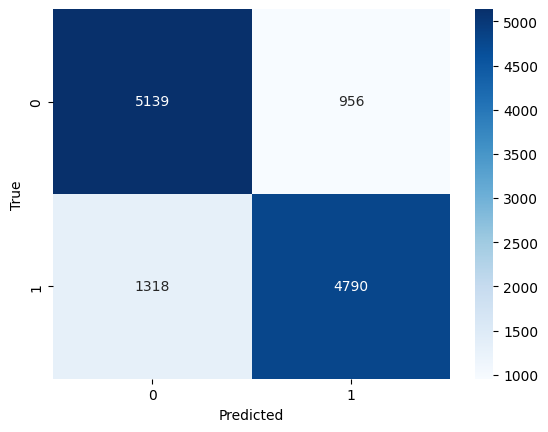

In [ ]:
#Evaluo en el set de test
y_pred= xgb_bestmodel.predict_proba(x_test)[:, 1]

#Matriz de Confusion
y_pred=xgb_bestmodel.predict(x_test)

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(y_test,y_pred))


##e. Construir un ensamble híbrido tipo Voting y otro tipo Stacking.

### Stacking

#### Preparacion

In [ ]:
import plotly.graph_objects as go
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from collections import defaultdict


In [ ]:
df_stackingtest = df_test.copy()

In [ ]:
df_stackingtest = df_stackingtest.drop(columns=['assigned_room_type', 'reserved_room_type', 'id', 'arrival_date'])

In [ ]:
df_stackingtest = df_stackingtest[features]
      

In [ ]:
#Funcion para evaluar los modelos 5fold -CV (repite 2 veces)
def evaluate_model(model, x, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    scores = cross_val_score(model, x, y, scoring='f1', cv=cv, verbose=1, n_jobs=3, error_score='raise')
    return scores

In [ ]:
#Funcion para plotear a performance
def plot_results(model_scores, name):
    
    model_names = list(model_scores.keys())
    results = [model_scores[model] for model in model_names]
    fig = go.Figure()
    for model, result in zip(model_names, results):
        fig.add_trace(go.Box(
            y=result,
            name=model,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker_size=2,
            line_width=1)
        )
    
    fig.update_layout(
    title='Performance of Different Models Using 5-Fold Cross-Validation',
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    xaxis_title='Model',
    yaxis_title='Accuracy',
    showlegend=False)
    fig.show()

In [ ]:
#Armo conjunto entrenamiento y test 80-20
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 42, train_size = 0.80)

In [ ]:
#Modelos Base
base_models = {'random_forest':RandomForestClassifier(n_estimators=50),
               'svm': SVC(),
               'knn': KNeighborsClassifier(n_neighbors=11)}

#Guarda los scores de cada modelo
model_scores = defaultdict()

#Entreno los clasificadores
for name, model in base_models.items():
    print('Evaluating {}'.format(name))
    scores = evaluate_model(model, x_train, y_train)
    model_scores[name] = scores

Evaluating random_forest


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   30.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating svm


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed: 24.3min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating knn


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   33.1s finished


In [ ]:
from sklearn.ensemble import StackingClassifier

#Modelos Base
base_models = [('random_forest', rf_cv_best),
               ('svm', svm_radial),
               ('knn', knn)]

#Meta Modelo
meta_model = LogisticRegressionCV()

#Ensemble Stacking
stacking_model = StackingClassifier(estimators=base_models, 
                                    final_estimator=meta_model, 
                                    passthrough=True, 
                                    cv=5,
                                    verbose=2)

In [ ]:
#Performance el modelo en entrenamiento
#stacking_scores = evaluate_model(stacking_model, x_train, y_train)
#model_scores['stacking'] = stacking_scores

In [ ]:
#Grafico performance
#plot_results(model_scores, name='stacking_model_cv')

#### Modelo

In [ ]:
#Evaluo en conjunto de test
#stacking_model.fit(x_train,y_train).score(x_test,y_test)
stacking_model.fit(x_train,y_train)
y_pred_st = stacking_model.predict(x_test)
f1_score(y_test, y_pred_st)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 an

0.8758542141230068

In [ ]:
predicciones_stacking = stacking_model.predict(df_stackingtest)


Text(50.722222222222214, 0.5, 'True')

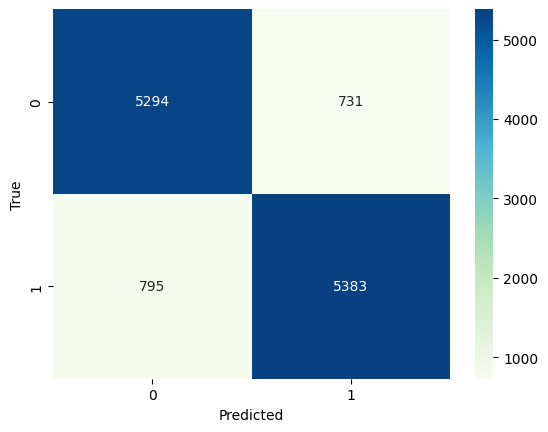

In [ ]:
#Creo la matriz de confusión
tabla=confusion_matrix(y_test, y_pred_st)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
print('accuracy: ' + str(accuracy_score(y_test, y_pred_st)))
print('f1_score: ' + str(f1_score(y_test, y_pred_st)))
print('recall: ' + str(recall_score(y_test, y_pred_st)))
print('precision: ' + str(precision_score(y_test, y_pred_st)))

accuracy: 0.8749487830861263
f1_score: 0.8758542141230068
recall: 0.8713175785043703
precision: 0.8804383382401046


### Voting


#### Preparacion

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
df_vottest = df_test.copy()

In [ ]:
df_vottest = df_vottest.drop(columns=['assigned_room_type', 'reserved_room_type', 'id', 'arrival_date'])

In [ ]:
df_vottest = df_vottest[features]
      

#### Modelo

In [ ]:

#Creo ensemble de Votación
vot_clf = VotingClassifier(estimators = [('svm', svm_radial), ('rnd', rf_cv_best), ('knn', knn)], voting = 'hard')

#Armo conjunto entrenamiento y test 80-20
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 42, train_size = 0.80)


#Entreno el ensemble
vot_clf.fit(x_train, y_train)

#Evaluo en conjunto de test
pred = vot_clf.predict(x_test)
accuracy_score(y_test, pred)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


0.8302056871261165

In [ ]:
f1_score(y_test, pred)

0.8337879030964223

Text(50.722222222222214, 0.5, 'True')

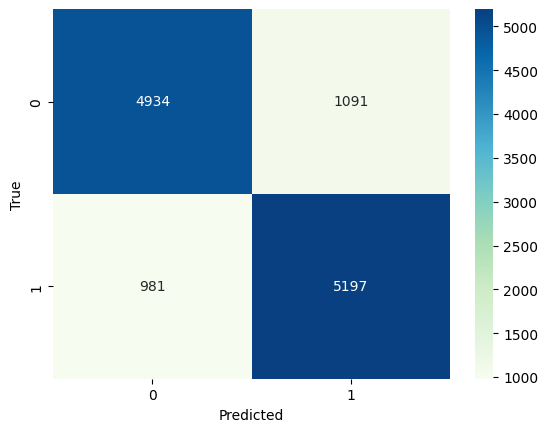

In [ ]:
#Creo la matriz de confusión
tabla=confusion_matrix(y_test, pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
print('accuracy: ' + str(accuracy_score(y_test, pred)))
print('f1_score: ' + str(f1_score(y_test, pred)))
print('recall: '+ str(recall_score(y_test, pred)))
print('precision: '+str(precision_score(y_test,pred)))

accuracy: 0.8302056871261165
f1_score: 0.8337879030964223
recall: 0.8412107478148269
precision: 0.8264949109414759


In [ ]:
predicciones_vot = vot_clf.predict(df_vottest.values)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [ ]:
df_submission = pd.DataFrame({'id':df_test['id'], 'is_canceled':predicciones_vot})
df_submission.head()
df_submission.shape

(26535, 2)

In [ ]:
#df_submission.to_csv('/content/drive/MyDrive/submissions/submission_voting_ensamble.csv', index=False)

In [ ]:
joblib.dump(vot_clf, 'vot_ensamble.plk')

['vot_ensamble.plk']